In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as style
from tqdm import tqdm 
tqdm.pandas()
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
style.use('ggplot')
import warnings
#warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import seaborn as sns
from sklearn.decomposition import PCA

In [58]:
df = pd.read_csv('all_data.csv')
grouped_df = df.groupby('department_name')
groups = list(grouped_df.groups.keys())

In [87]:
X_depts, y_depts = [], []
corrs = []
time_vectors = []
for n, dept in enumerate(groups):
    df_dept = grouped_df.get_group(dept)
    df_dept = df_dept.sort_values('date')
    X = df_dept['incidents'].to_numpy().reshape(-1,1)
    idx = np.r_[0:4,5:8]
    df_dept = df_dept[df_dept.columns[idx]].dropna()
    time_vectors.append(df_dept['date'])
    corrs.append(df_dept.corr())
    X = df_dept[df_dept.columns[1:-1]].to_numpy()
    y = df_dept[df_dept.columns[-1]].to_numpy().reshape(-1,1)
    X_depts.append(X)
    y_depts.append(y)

<AxesSubplot:>

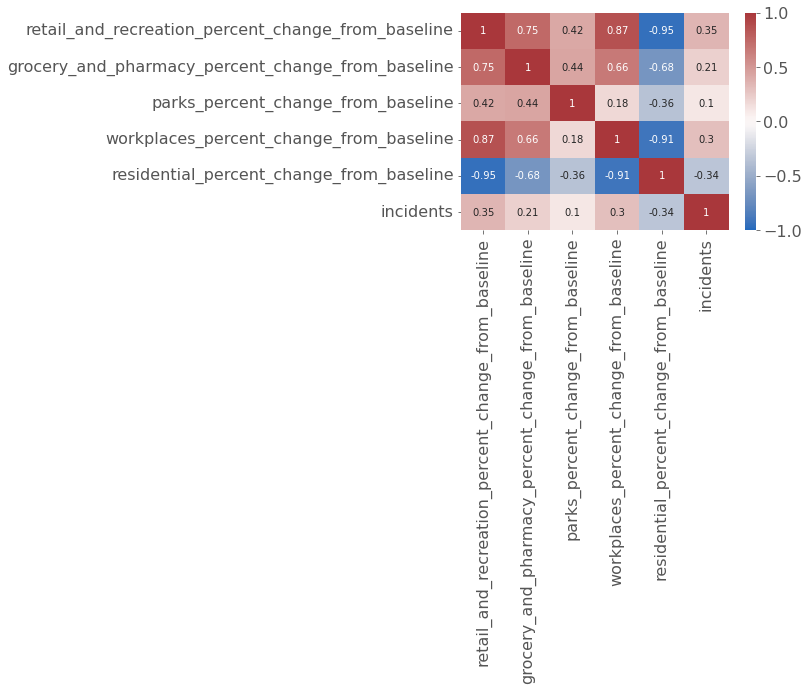

In [55]:
df_concat = pd.concat(corrs)
by_row_index = df_concat.groupby(df_concat.index)
df_means = by_row_index.mean()
sns.heatmap(df_means.loc[df_means.columns], cmap='vlag',vmin=-1, vmax=1, annot=True)


<AxesSubplot:>

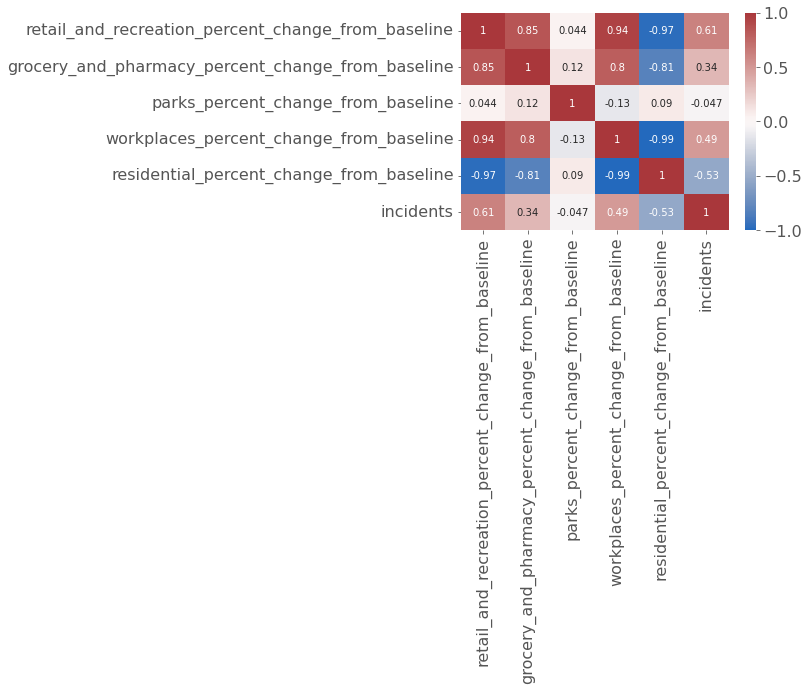

In [74]:
sns.heatmap(corrs[15], cmap='vlag',vmin=-1, vmax=1, annot=True)

In [90]:
X_depts[1].shape

(40, 5)

In [92]:
pca = PCA(n_components=2)
X_transformed = []
for n, dept in enumerate(groups):
    X_transform = pca.fit_transform(X_depts[n])   
    X_transformed.append(X_transform)
   # print(pca.explained_variance_ratio_)

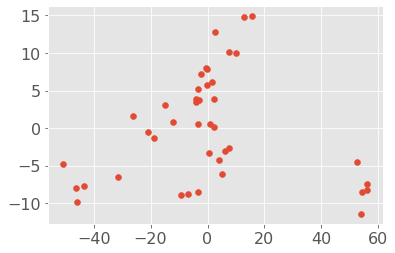

In [93]:
plt.scatter(X_transform[:,0], X_transform[:,1])

In [94]:
palette = sns.color_palette("Set2")

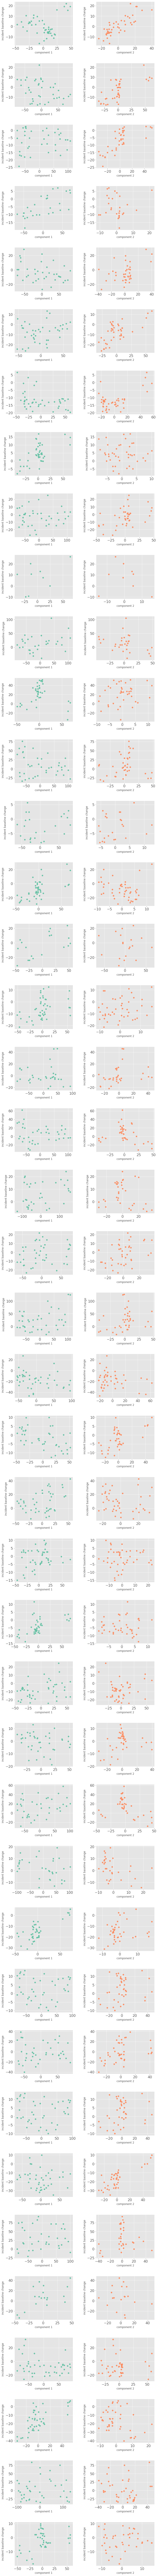

In [97]:
plt.figure(figsize=(30, 200))
for n, dept in enumerate(groups):
    X, y = X_transformed[n], y_depts[n]
    for i in range(X.shape[1]):
        plt.subplot(len(groups), 5, 5*n+i + 1)
        plt.scatter(X[:,i], y, color=palette[i])
        plt.ylabel('incident baseline change')
        plt.xlabel(f'component {i+1}')
        if i ==2:
            plt.title(dept)
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)    
    
plt.savefig('basic_plots.png',bbox_inches='tight', dpi=200)   

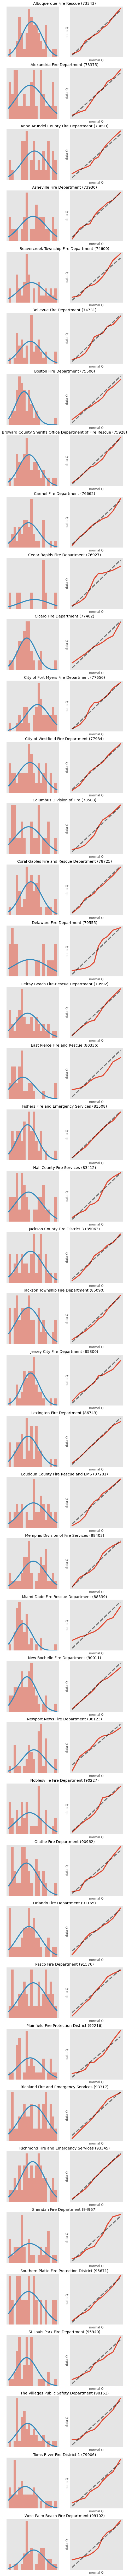

In [98]:
plt.figure(figsize=(8, 180))
all_residuals = []
    
for n, dept in enumerate(groups):
    plt.subplot(len(groups), 2, 2*n + 1)
    X, y = X_transformed[n], y_depts[n]
    reg = LinearRegression()
    reg.fit(X, y)
    residuals = y - reg.predict(X)
    all_residuals.append(residuals)
    plt.hist(residuals, alpha=.5, density=True, bins=20)
    plt.xticks([])
    plt.yticks([])
    plt.title(dept, x=1.1)
    mean = np.mean(residuals)
    var = np.var(residuals)
    min_x, max_x = np.min(residuals), np.max(residuals)
    x = np.linspace(min_x, max_x, 100)
    normal = norm(loc=mean, scale=np.sqrt(var))
    norm_pdf = normal.pdf(x)
    plt.plot(x, norm_pdf)
    plt.subplot(len(groups), 2, 2*n + 2)
    quants = np.linspace(0.1, 0.9, 10)
    quantiles_norm = normal.ppf(quants)
    quantiles_data = np.quantile(residuals, quants)
    plt.plot(quantiles_norm, quantiles_data)
    plt.xlabel('normal Q')
    plt.ylabel('data Q')
    plt.xticks([])
    plt.yticks([])
    plt.plot([quantiles_norm.min(), quantiles_norm.max()],[quantiles_norm.min(), quantiles_norm.max()], color='black', alpha=.5, linestyle='--')

plt.savefig('normal_approx.png',bbox_inches='tight')
    
    
    
    
    

In [99]:
all_days_2020 = pd.DataFrame(pd.date_range("2020", freq="D", periods=365))
all_days_2020.columns = ['date']
mondays_of_2020 = all_days_2020[all_days_2020['date'].dt.dayofweek == 0].reset_index()

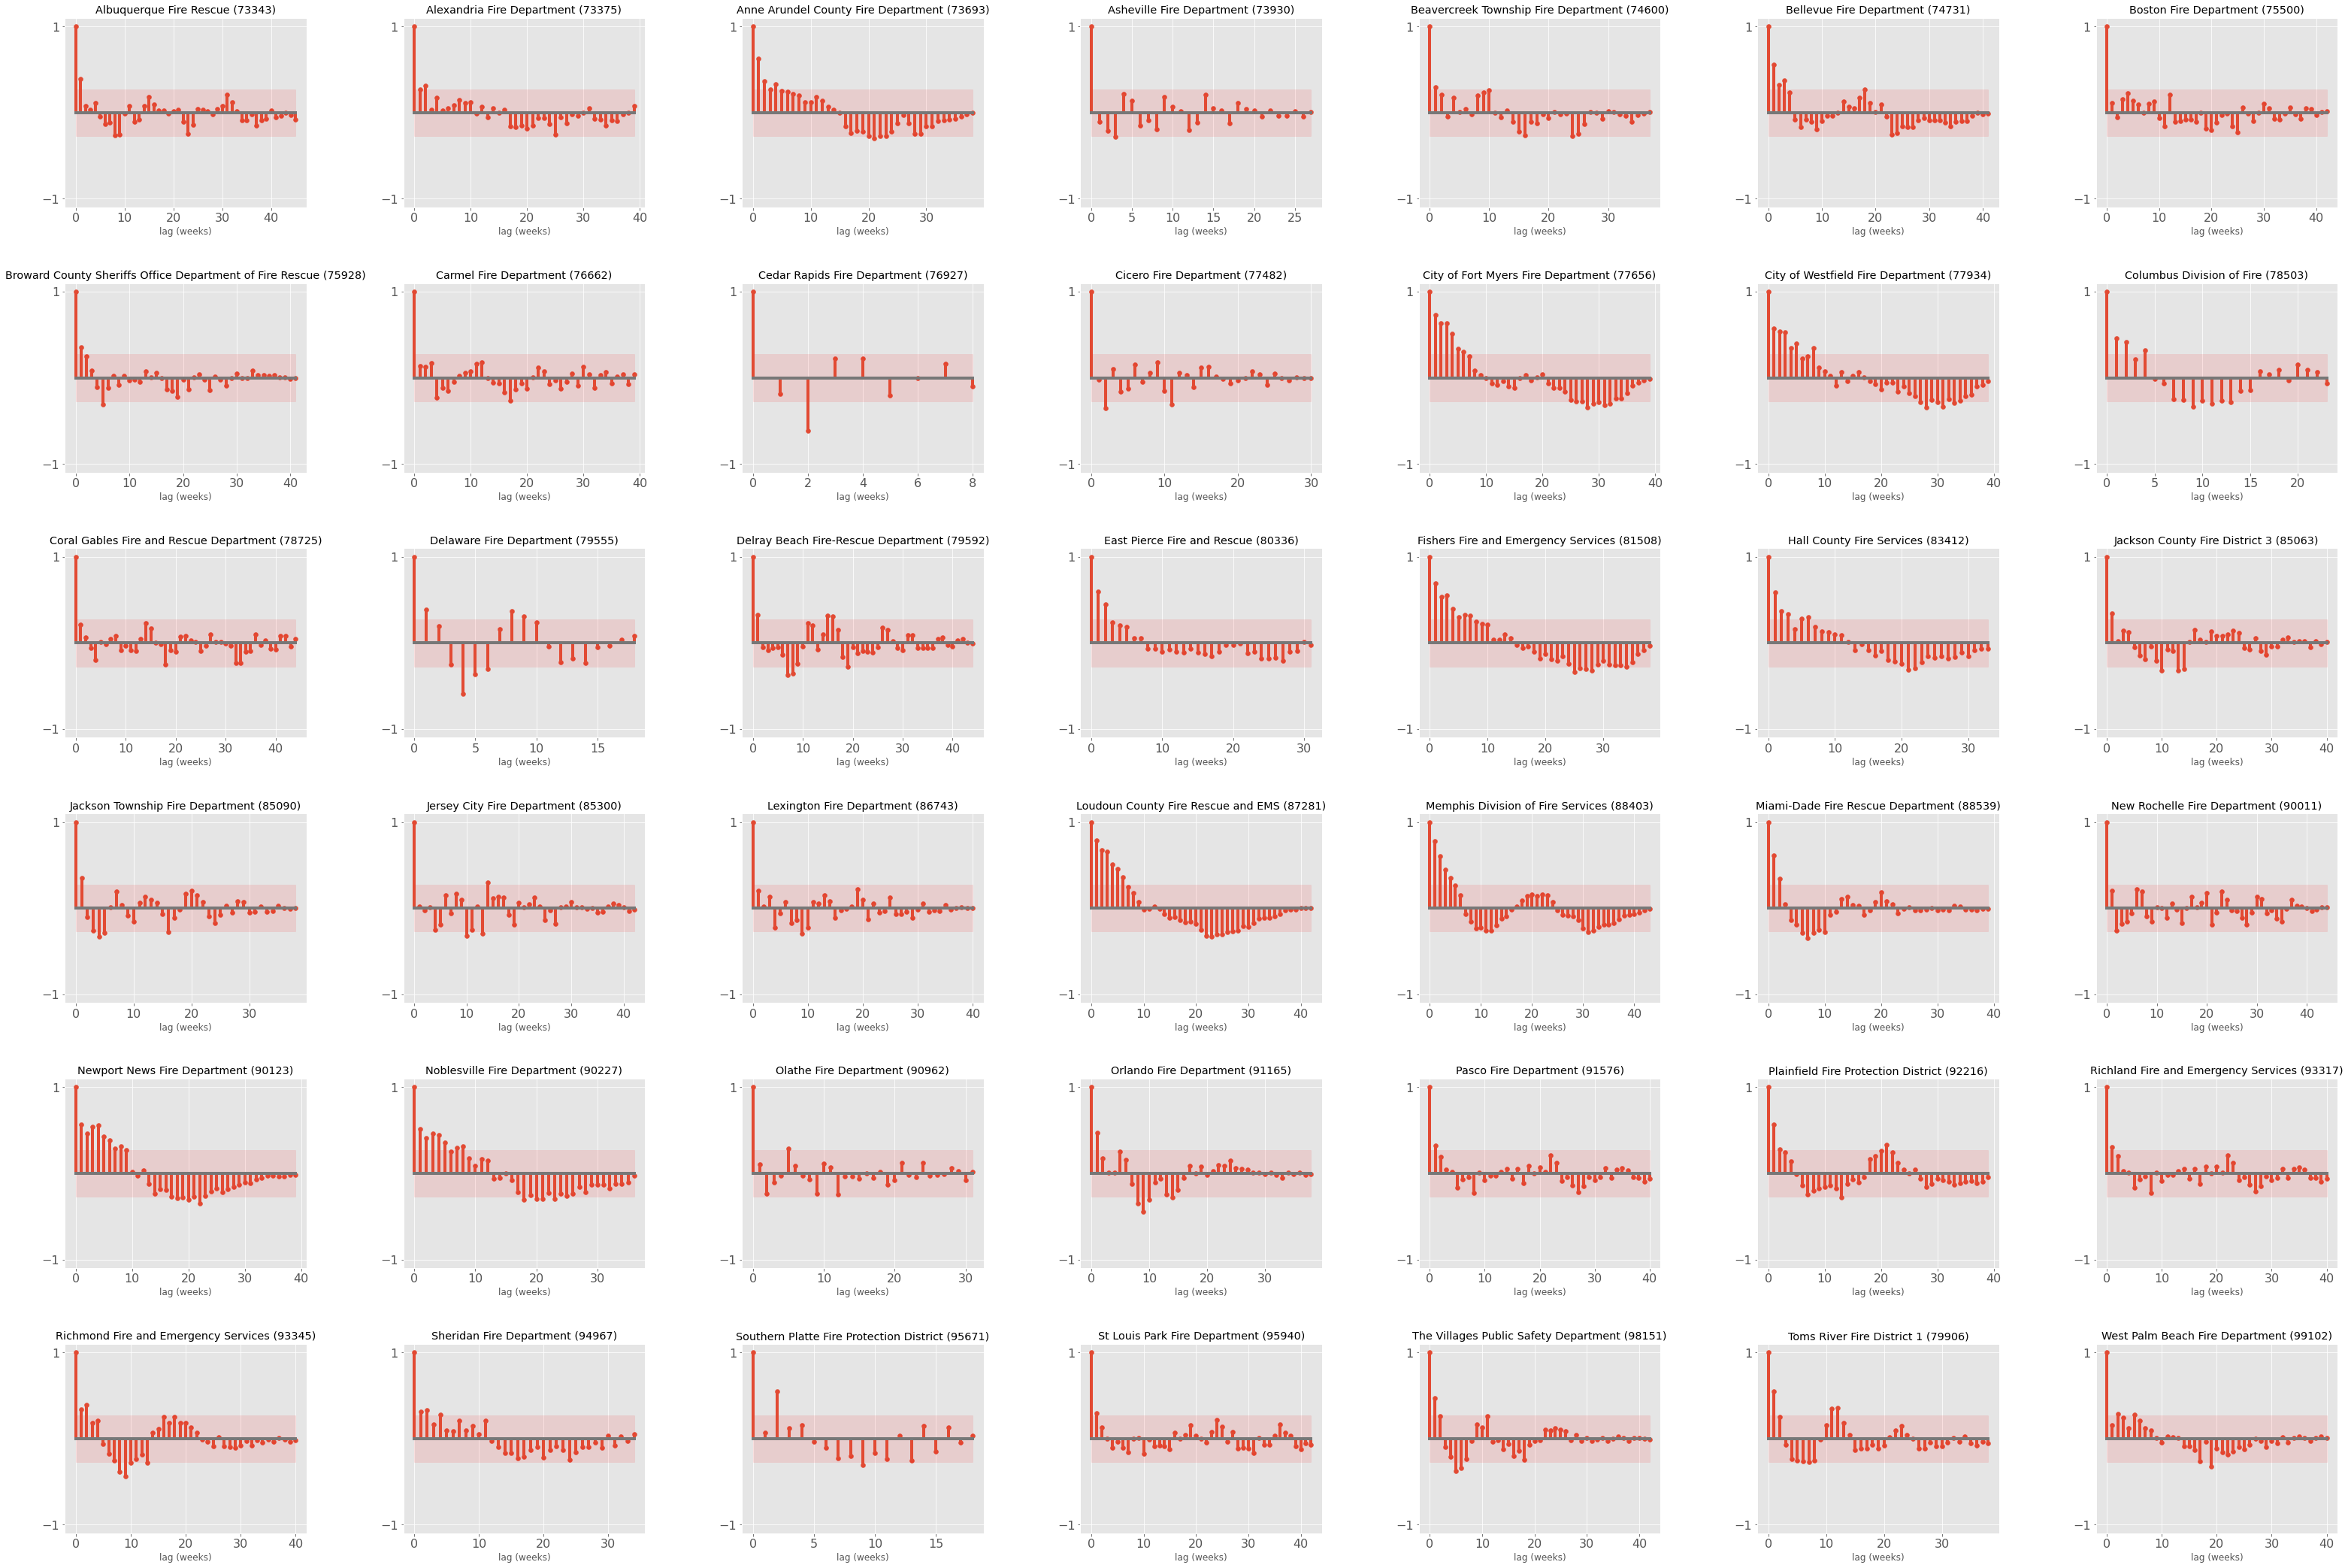

In [100]:
plt.figure(figsize=(30, 35))

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
corr_dfs = []
for i in range(len(all_residuals)):
    plt.subplot(6, 7, i + 1)
    df_corr = pd.DataFrame(data = np.vstack([time_vectors[i], all_residuals[i].flatten()]).T)
    df_corr.columns = ['date', 'residual']
    df_corr['date'] =  pd.to_datetime(df_corr['date'])
    merged_df = pd.merge(mondays_of_2020, df_corr, how='outer', on='date')
    corr_dfs.append(merged_df)
    data, CI = acf(merged_df['residual'],  nlags=len(all_residuals[i])-1,  missing='drop', alpha=.05, bartlett_confint = False
)
    lags = np.arange(0, len(all_residuals[i]), 1)
    plt.scatter(lags, data)
    plt.stem(lags, data, markerfmt=' ')
    plt.ylim(-1.1,1.1)
    plt.yticks([-1,1])
    plt.xlabel('lag (weeks)')
    plt.fill_between(lags,CI[:,0]-data, CI[:,1]-data, alpha=.1, color='red')
    plt.title(groups[i])
    
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)   
plt.savefig('acf_plots.png',bbox_inches='tight', dpi=200)   
   

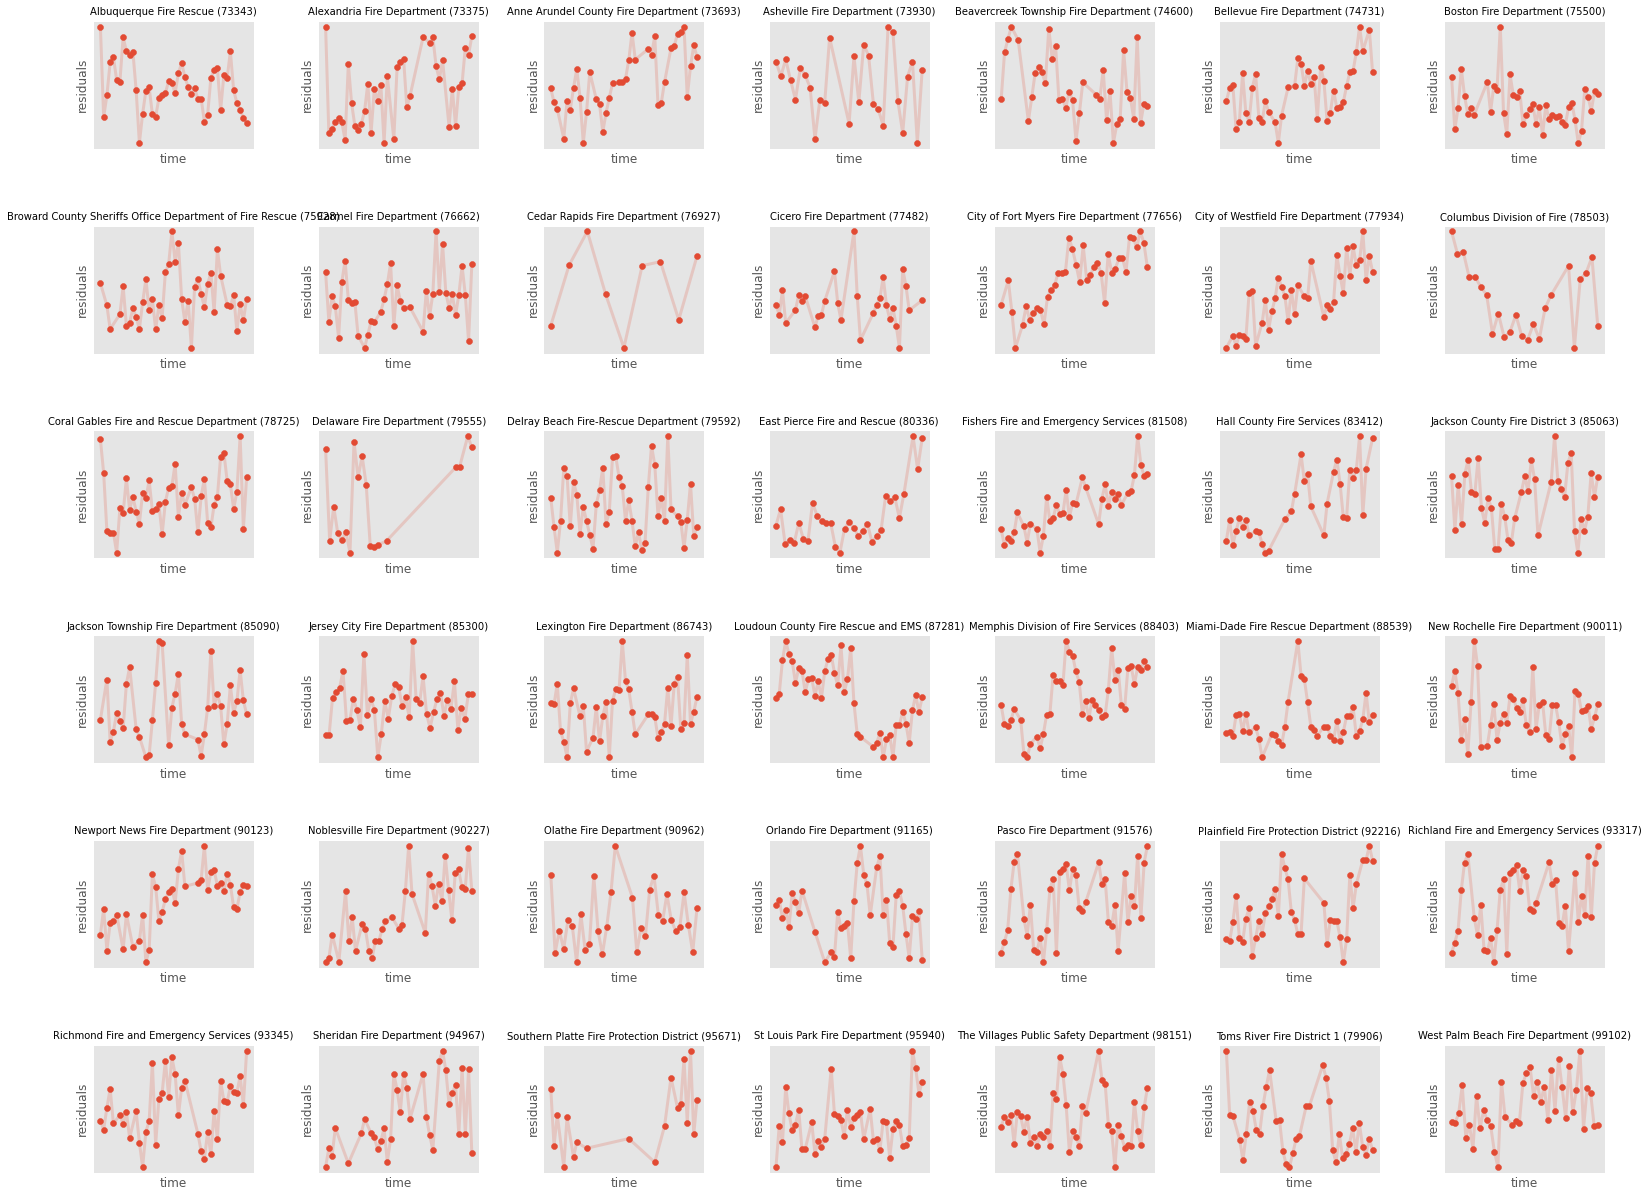

In [101]:
plt.figure(figsize=(15, 20))
for i in range(len(all_residuals)):
    merged_df = corr_dfs[i].dropna()
    plt.subplot(6, 7, i + 1)
    plt.scatter(merged_df['date'], merged_df['residual'])
    plt.plot(merged_df['date'], merged_df['residual'], alpha=0.2, lw=3)
    
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('time')
    plt.ylabel('residuals')
    plt.title(groups[i], fontsize=10)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)   
plt.savefig('res_plots.png',bbox_inches='tight', dpi=200)   
